### Case Aluguéis de Carros

### Imports

In [1]:
# manipulação de dados
import numpy as np
import pandas as pd
import random

# análises graficas
import matplotlib.pyplot as plt

# utilidades
from tqdm import tqdm

# machine learning
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

### Métodos Auxiliares

In [2]:
def show_missings(df):
    '''
    mostra porcentagem de missings no dataframe
    '''
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     
                                     'percent_missing': percent_missing})

    missing_value_df = missing_value_df.sort_values('percent_missing', ascending=False).round(2)
    return (missing_value_df)

def group_values(df, column, target):
    '''
    agrupa valores, calculando quantidade e média
    '''
    df_count = (
      df
      .groupby(column, as_index=True)
      .agg({target: 'count'})
      .reset_index()
      .rename(columns={target: 'Volume (#)'})
    )

    df_target = (
      df
      .groupby(column, as_index=True)
      .agg({target: 'mean'})
      .reset_index()
    )
    
    # merge
    df_groupby = pd.merge(df_count, df_target, on=[column])
    
    # columns
    df_groupby.columns = [column, 'Volume (#)', target]
    df_groupby['Volume (%)'] = 100 * (df_groupby['Volume (#)'] / df_groupby['Volume (#)'].sum())
    df_groupby = df_groupby[[column, 'Volume (#)', 'Volume (%)', target]]
    df_groupby = df_groupby.sort_values(by=[target], ascending=False)
    return df_groupby

### Exercícios

Assuma que se deseja prever a soma do número de diárias de carros a serem vendidas nos próximos 7 dias em cada agência, em função do preço médio a ser arbitrado para cada tipo de carro em cada agência.
 
Os dados históricos de vendas estão em um arquivo CSV (ou em uma tabela SQL) com as seguintes colunas e respectivos dados em cada linha, onde cada linha corresponde a uma venda:
 
- COD_AG: código da agência
- NUM_NOTA: número da nota fiscal
- DATA: data correspondente à venda
- COD_TIPO_CARRO: código do tipo de carro que foi alugado
- NUM_DIARIAS: número de diárias vendidas
- VALOR: valor total da nota fiscal

Note que:
 
Múltiplas vendas do mesmo tipo de carro podem ocorrer no mesmo dia e na mesma agência, cada uma com preço potencialmente diferente.
O preço unitário de uma diária em uma venda pode ser calculado pela divisão VALOR/NUM_DIARIAS.
A DATA pode ser assumida como um número inteiro entre 1 e 7000, onde esse número corresponde ao número de dias desde o início da operação da empresa.
Você pode assumir que há aluguel de todos os tipos de carros em todas as agências ao longo de todos os dias do histórico.

### Construção do Dataset

In [3]:
df = pd.DataFrame()
n_elementos = 500_000 # dataset com 500 mil registros de aluguéis de carros
n_agencias = 5 # 5 agências
n_carros = 7 # 7 modelos de carros
n_dias = 7_000 # quantidade de dias (~19 anos)
df["COD_AG"] = random.choices([f"AGENCIA_{x}" for x in range(n_agencias)], k=n_elementos) # gências criadas
df["NUM_NOTA"] = random.choices(range(n_elementos*10), k=n_elementos) # IDs criados aleatoriamente
df["DATA"] = np.random.choice(range(1, n_dias+1), size=n_elementos, replace=True) # data aleatória entre 1 e 7000
df["COD_TIPO_CARRO"] = random.choices([f"CARRO_{x}" for x in range(n_carros)], k=n_elementos) # carros criados
df["NUM_DIARIAS"] = [int(np.abs(x)) for x in np.random.normal(8, 2, n_elementos)] # amostra de uma normal
df["VALOR_MEDIO"] = [round(np.abs(x), 2) for x in np.random.normal(230, 100, n_elementos)] # amostra de uma normal
df["VALOR"] = df["NUM_DIARIAS"] * df["VALOR_MEDIO"] # multiplica (para ser mais coerente)
df = df.drop(columns=["VALOR_MEDIO"])
print('Shape do df criado artificialmente:', df.shape)

# salva dados em um arquivo csv
df.to_csv('Dados.csv', sep=';', index=False)

# primeiras 5 linhas
df.head()

Shape do df criado artificialmente: (500000, 6)


,COD_AG,NUM_NOTA,DATA,COD_TIPO_CARRO,NUM_DIARIAS,VALOR
0,AGENCIA_0,1518322,4165,CARRO_4,7,2584.40
1,AGENCIA_0,497213,5229,CARRO_2,8,1346.32
2,AGENCIA_0,503979,1860,CARRO_3,6,2507.82
3,AGENCIA_3,4024357,3217,CARRO_2,6,2550.72
4,AGENCIA_1,2916562,4347,CARRO_5,3,951.84


### Análise Exploratória dos Dados (EDA)

In [4]:
# informações gerais do dataset criado
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   COD_AG          500000 non-null  object 
 1   NUM_NOTA        500000 non-null  int64  
 2   DATA            500000 non-null  int64  
 3   COD_TIPO_CARRO  500000 non-null  object 
 4   NUM_DIARIAS     500000 non-null  int64  
 5   VALOR           500000 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 22.9+ MB


In [5]:
# não existem dados sem preenchimento no dataset
show_missings(df)

,column_name,percent_missing
COD_AG,COD_AG,0.0
NUM_NOTA,NUM_NOTA,0.0
DATA,DATA,0.0
COD_TIPO_CARRO,COD_TIPO_CARRO,0.0
NUM_DIARIAS,NUM_DIARIAS,0.0
VALOR,VALOR,0.0


### Análises Univariadas

Text(0, 0.5, 'Frequência')

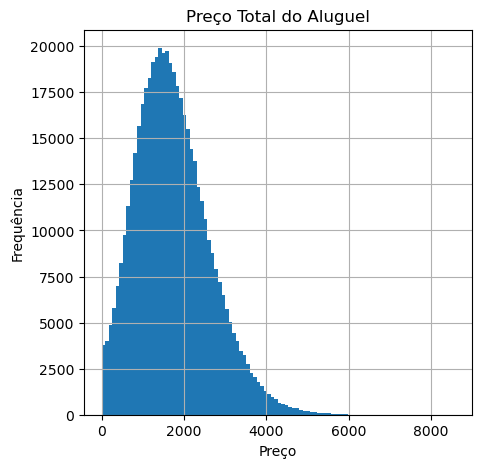

In [6]:
# Histograma do preço total
df_eda = df.copy()
df_eda['VALOR'].hist(bins=100, figsize=(5,5))
plt.title('Preço Total do Aluguel')
plt.xlabel('Preço')
plt.ylabel('Frequência')

Text(0, 0.5, 'Frequência')

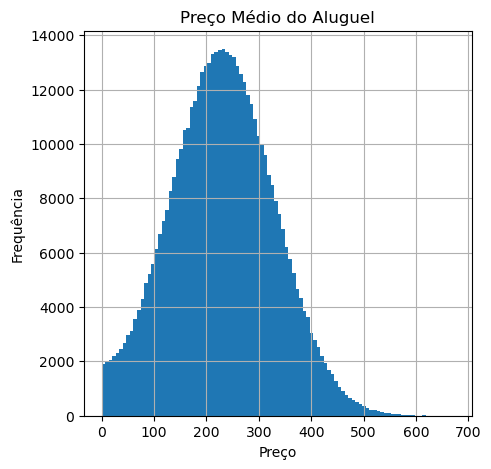

In [7]:
# Preço do aluguel dividido pelo número de diárias
df_eda['VALOR_MEDIO'] = df_eda['VALOR'] / df_eda['NUM_DIARIAS']
df_eda['VALOR_MEDIO'].hist(bins=100, figsize=(5,5))
plt.title('Preço Médio do Aluguel')
plt.xlabel('Preço')
plt.ylabel('Frequência')

Text(0, 0.5, 'Frequência')

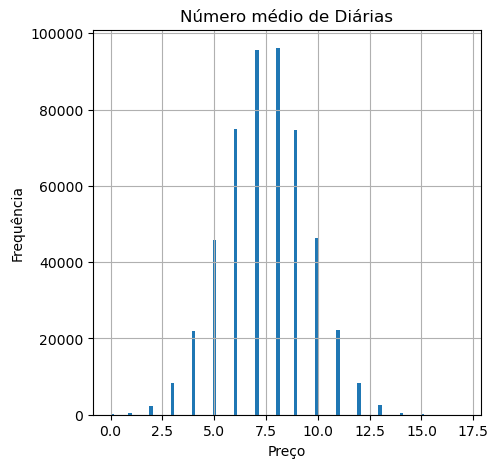

In [8]:
# QUantidade de diárias
df_eda['NUM_DIARIAS'].hist(bins=100, figsize=(5,5))
plt.title('Número médio de Diárias')
plt.xlabel('Preço')
plt.ylabel('Frequência')

In [9]:
# agrupando por agência
group_values(df_eda, 'COD_AG', 'VALOR')

,COD_AG,Volume (#),Volume (%),VALOR
4,AGENCIA_4,100023,20.0046,1733.088055
3,AGENCIA_3,99887,19.9774,1732.206509
1,AGENCIA_1,100332,20.0664,1731.459616
0,AGENCIA_0,99886,19.9772,1728.702712
2,AGENCIA_2,99872,19.9744,1728.213865


In [10]:
# agrupando por modelo do carro
group_values(df_eda, 'COD_TIPO_CARRO', 'VALOR')

,COD_TIPO_CARRO,Volume (#),Volume (%),VALOR
3,CARRO_3,71539,14.3078,1736.817175
6,CARRO_6,71176,14.2352,1735.368413
1,CARRO_1,71693,14.3386,1732.697101
2,CARRO_2,71322,14.2644,1729.765774
4,CARRO_4,71331,14.2662,1728.114911
0,CARRO_0,71620,14.3240,1726.453076
5,CARRO_5,71319,14.2638,1725.930966


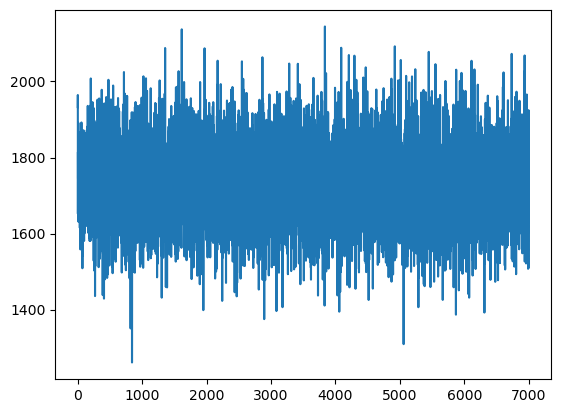

In [11]:
# Valor médio por dia ao longo do tempo
df_valor_medio_tempo = (
      df_eda
      .groupby('DATA', as_index=True)
      .agg({'VALOR': 'mean'})
      .reset_index()
    )
plt.plot(df_valor_medio_tempo['VALOR'])

### Questões

1) Escreva o código (usando SQL; Python com Pandas ou Spark; ou R) correspondente à preparação do seguinte dataframe (ou tabela SQL) para a criação de um modelo preditivo:
 
 
- DATA_REF: data de referência (i.e. valores correspondem a 7 dias a partir dessa data)
- COD_AG: código da agência
- COD_TIPO_CARRO: código do tipo de carro
- PRECO_MEDIO: preço médio ponderado por número de diárias do tipo de carro no período de referência e na agência
- DELTA_PRECO_MEDIO: variação percentual do preço médio ponderado entre semana anterior (entre DATA_REF-7dias e DATA_REF-1 dia, incluindo os limites) e semana atual (entre DATA_REF e DATA_REF+6 dias, incluindo os limites)
- NUM_DIARIAS_SEMANA_ANTERIOR: número total de diárias vendidas na semana anterior (entre DATA_REF-7dias e DATA_REF-1 dia, incluindo os limites)
- NUM_DIARIAS_SEMANA: número total de diárias vendidas na semana atual (entre DATA_REF e DATA_REF+6 dias, incluindo os limites)

In [12]:
%%time
# Iterar pelas datas de referência para criar as novas colunas do dataframe
dados_modelagem = []
for data_ref in tqdm(range(1, n_dias+1)):
    semana_anterior_inicio = data_ref - 7
    semana_anterior_fim = data_ref - 1
    semana_atual_inicio = data_ref
    semana_atual_fim = data_ref + 6

    # Filtrar os dados para a semana anterior e a semana atual
    dados_semana_anterior = df[(df['DATA'] >= semana_anterior_inicio) & (df['DATA'] <= semana_anterior_fim)]
    dados_semana_atual = df[(df['DATA'] >= semana_atual_inicio) & (df['DATA'] <= semana_atual_fim)]

    # Calcular o preço médio ponderado para cada tipo de carro na agência
    # na semana anterior e na semana atual
    for cod_ag, cod_tipo_carro in df[['COD_AG', 'COD_TIPO_CARRO']].drop_duplicates().values:
        # daods da semana anterior
        filtro_ag_tipo_carro_semana_anterior = (
            (dados_semana_anterior['COD_AG'] == cod_ag) &
            (dados_semana_anterior['COD_TIPO_CARRO'] == cod_tipo_carro)
        )
        # dados da semana atual
        filtro_ag_tipo_carro_semana_atual = (
            (dados_semana_atual['COD_AG'] == cod_ag) &
            (dados_semana_atual['COD_TIPO_CARRO'] == cod_tipo_carro)
        )

        # diárias
        dados_anteriores = dados_semana_anterior.loc[filtro_ag_tipo_carro_semana_anterior, 'NUM_DIARIAS']
        dados_atuais = dados_semana_atual.loc[filtro_ag_tipo_carro_semana_atual, 'NUM_DIARIAS']
        num_diarias_semana_anterior = dados_anteriores.sum()
        num_diarias_semana_atual = dados_atuais.sum()

        # preco medio semana anterior
        if len(dados_anteriores) > 0 and num_diarias_semana_anterior > 0:
            preco_medio_semana_anterior = dados_semana_anterior.loc[filtro_ag_tipo_carro_semana_anterior, 'VALOR'].sum() / num_diarias_semana_anterior
        else:
            preco_medio_semana_anterior = np.nan

        # preco medio semana atual
        if len(dados_atuais) > 0 and num_diarias_semana_atual > 0:
            preco_medio_semana_atual = dados_semana_atual.loc[filtro_ag_tipo_carro_semana_atual, 'VALOR'].sum() / num_diarias_semana_atual
        else:
            preco_medio_semana_atual = np.nan

        # delta preco medio (%)
        if preco_medio_semana_anterior != 0:
            delta_preco_medio = 100 * ((preco_medio_semana_atual - preco_medio_semana_anterior) / preco_medio_semana_anterior)
        else:
            delta_preco_medio = np.nan

        # incrementa dados
        dados_modelagem.append({
            'DATA_REF': data_ref,
            'COD_AG': cod_ag,
            'COD_TIPO_CARRO': cod_tipo_carro,
            'PRECO_MEDIO': preco_medio_semana_atual,
            'DELTA_PRECO_MEDIO': delta_preco_medio,
            'NUM_DIARIAS_SEMANA_ANTERIOR': num_diarias_semana_anterior,
            'NUM_DIARIAS_SEMANA': num_diarias_semana_atual,
        })

# Criar o novo dataframe com os dados gerados
df_modelagem = pd.DataFrame(dados_modelagem)
df_modelagem.to_csv('df_modelagem.csv', sep=';', index=False)
df_modelagem.head()

100%|███████████████████████████████████████| 7000/7000 [12:38<00:00,  9.23it/s]


CPU times: user 12min 4s, sys: 38.3 s, total: 12min 43s
Wall time: 12min 40s


,DATA_REF,COD_AG,COD_TIPO_CARRO,PRECO_MEDIO,DELTA_PRECO_MEDIO,NUM_DIARIAS_SEMANA_ANTERIOR,NUM_DIARIAS_SEMANA
0,1,AGENCIA_0,CARRO_4,211.442523,NaN,0,107
1,1,AGENCIA_0,CARRO_2,214.507391,NaN,0,92
2,1,AGENCIA_0,CARRO_3,234.689712,NaN,0,104
3,1,AGENCIA_3,CARRO_2,237.099570,NaN,0,93
4,1,AGENCIA_1,CARRO_5,263.932411,NaN,0,112


2) Proponha conjunto de “features” adicionais que possam ajudar na previsão futura, a serem adicionadas no dataframe. Note que há uma infinidade de “features” que podem ser úteis ao se agregar as vendas por semana e ao se considerar o histórico.

##### Resposta

1. Variáveis explicativas internas
- Defasagem de valores e qtd por agência e modelo em outras janelas de tempo (semana de Mês-1, semana de Ano-1)
- Valores médios por agência e carro históricos, tanto da agência quanto das agências mais próximas ou parecidas
- Dados sobre a agência (quantidade de funcionários, tempo de operação, distância até aeroporto ou rodoviária)
- Dados sobre o carro (valor médio no mercado, popularidade, ano, km percorridos, estado do carro, etc)

2. Variáveis explicativas externas
- Eventos baseados em calendário (ex. mês do ano, férias escolares, feriados, etc)
- Dados climáticos (ex. previsão do tempo em cada cidade, temperatura média estimada, etc)
- Dados do IBGE ou Bureaus externos (ex. Renda média por município, escolaridade, idade, perfil de público)
- Dados sobre a cidade (quantidade de habitantes, renda média dos habitantes)
- Informações sobre a concorrência (i.e. existem concorrentes próximos à agência?)
- Valores macroeconômicos (inflação, desemprego, turismo, saúde, pandemias, etc)

3. Variáveis explicativas adicionais
- Normalização dos dados disponíveis
- Transformações (ex. log)
- Criação de novos campos (ex. dividindo ou multiplicando valores)

3) Explique como faria o treinamento e o teste do modelo.

##### Resposta

Eu utilizaria todas as variáveis explicativas disponíveis (internas e/ou externas) para prever a soma do número de diárias de carros a serem vendidas nos próximos 7 dias em cada agência (coluna NUM_DIARIAS_SEMANA do dataframe), em função do preço médio (coluna PRECO_MEDIO) a ser arbitrado para cada tipo de carro em cada agência.

Seria interessante criar um conjunto de teste contendo dados futuros ao treinamento do modelo, de forma a coletar uma estimativa não enviesada do desempenho do modelo em produção. Como o dataset possui aproximadamente 19 anos (7000 dias) de informações, minha abordagem seria utilizar o ano mais recente como teste (junho/2022 a maio/2023, por exemplo).

Para separar os dados de treino em treino e validação, existem algumas abordagens possíveis e uma pode ser melhor que a outra dependendo de como o modelo for ser usado na prática e da evolução da quantidade de agências e carros ao longo do tempo. É possível fazer outra separação temporal (por ex. 17 anos anos para treino e 1 para validação), mas isso poderia sacrificar os dados mais recentes para treinar o modelo, o que não seria interessante caso tenham surgido novos carros e agências. Minha preferência de abordagem é fazer um split temporal (ex. método TimeSeriesSplit), garantindo que o modelo sempre será validado em dados futuros ao treino e sem sacrificar o ano mais recente para desenvolver o modelo. Contudo, é interessante analisar se realmente faria sentido treinar o modelo com todos os 18 anos de histórico ao invés dos últimos 5 anos, por exemplo.

Uma vez definidos os conjuntos de treino, validação (criados usando TimeSeriesSplit) e teste (out of time puro), eu treinaria diversos modelos (ex. algoritmos baseados em árvores, SVM, redes neurais, regressão linear, etc) na base de dados disponível, tunando hiperparâmetros com uma abordagem bayesiana. Após eleger o melhor modelo (já com as variáveis finalistas que discriminam o target) com base nas métricas de regressão consideradas (ex. RMSE, R2, MAE, etc) para o conjunto de treino e validação eleitos, estar satisfeito com os resultados no conjunto de teste, e também as áreas clientes estarem satisfeitas com o resultado apresentado, o modelo está finalizado e poderá ser implantado, pilotado e monitorado em ambiente produtivo. Se não houver restrições adicionais, pode ser interessante treinar o modelo finalista com todo o conjunto de dados disponíveis (caso realmente faça sentido utilizar dados relativos a dados de muitos anos atrás).

### Separa dados em treino e teste (apenas um exemplo de como poderia ser feito!)

In [13]:
feature_cols = ['COD_AG', 'COD_TIPO_CARRO', 'PRECO_MEDIO', 'NUM_DIARIAS_SEMANA_ANTERIOR']
target = 'NUM_DIARIAS_SEMANA'

df_modelagem['COD_AG'] = df_modelagem['COD_AG'].astype('category')
df_modelagem['COD_TIPO_CARRO'] = df_modelagem['COD_TIPO_CARRO'].astype('category')
df_treino = df_modelagem.query("DATA_REF >= 5000 and DATA_REF < 6600")
df_teste = df_modelagem.query("DATA_REF >= 6600 and DATA_REF <= 6990")
print('treino:', df_treino.shape)
print('teste:', df_teste.shape)

X_teste = df_teste[feature_cols]
y_teste = df_teste[target]

treino: (56000, 7)
teste: (13685, 7)


### Treinamento do modelo (apenas uma ilustração)

In [14]:
# resultados
resultados = []

# time series split
tscv = TimeSeriesSplit(n_splits=10)

# treina modelo (ex. lgbm)
iterador = 1
for train_index, test_index in tscv.split(df_modelagem):
    dados_treino = df_modelagem.loc[train_index]
    dados_teste = df_modelagem.loc[test_index]

    X_treino, y_treino = dados_treino[feature_cols], dados_treino[target]
    X_val, y_val = dados_teste[feature_cols], dados_teste[target]

    # dataset
    dataset_treino = lgb.Dataset(X_treino, label=y_treino)

    #  hiperparametros (apenas um exemplo, idealmente deveriam ser otimizados!)
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }

    # treina modelo
    model = lgb.train(lgb_params, dataset_treino)

    # predições no conjunto de treino
    y_treino_pred = model.predict(X_treino, num_iteration=model.best_iteration)
    
    # predições no conjunto de validação
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    # predições no conjunto de teste
    y_teste_pred = model.predict(X_teste, num_iteration=model.best_iteration)

    # calcula RMSE
    rmse_treino = round(np.sqrt(mean_squared_error(y_treino, y_treino_pred)),2)
    rmse_val = round(np.sqrt(mean_squared_error(y_val, y_val_pred)),2)
    rmse_teste = round(np.sqrt(mean_squared_error(y_teste, y_teste_pred)),2)
    
    resultados.append([iterador, rmse_treino, rmse_val, rmse_teste])
    iterador+=1
    
# resultados
df_resultados = pd.DataFrame(resultados, columns=['Split', 'RMSE Treino', 'RMSE Validação', 'RMSE Teste'])
df_resultados

,Split,RMSE Treino,RMSE Validação,RMSE Teste
0,1,27.54,29.18,29.10
1,2,28.20,29.30,29.03
2,3,28.53,29.33,29.02
3,4,28.69,29.00,29.00
4,5,28.74,28.64,28.94
5,6,28.72,28.94,28.95
6,7,28.75,28.72,28.94
7,8,28.74,28.80,28.95
8,9,28.75,29.23,28.95
9,10,28.79,29.14,28.95


In [15]:
# Resultados médios obtidos
df_resultados[['RMSE Treino', 'RMSE Validação', 'RMSE Teste']].mean()

RMSE Treino       28.545
RMSE Validação    29.028
RMSE Teste        28.983
dtype: float64